In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from ethicml.algorithms.inprocess import LR, SVM, Majority, ZafarAccuracy, ZafarFairness, Kamiran, Agarwal
from ethicml.metrics import Accuracy, AbsCV, ProbPos, TPR, TNR, F1, BalancedAccuracy
from ethicml.preprocessing import BalancedTestSplit
from ethicml.evaluators import evaluate_models_async, load_results
from ethicml.data import Adult, load_data
from ethicml.visualisation import plot_results, single_plot
from ethicml.utility import Results

In [3]:
rate_y1_s0_sex = 0.11451785988042312
rate_y1_s1_sex = 0.31711446448288555
rate_avg_sex = 0.21581616218

rate_y1_s0_race = 0.1561938958707361
rate_y1_s1_race = 0.26669745425157304
rate_avg_race = 0.21144567506

In [30]:
df_race = pd.read_csv("results/dp_balanced_test_10repeats_Adult Race-Binary_no_transform.csv")
df_sex = pd.read_csv("results/dp_balanced_test_10repeats_Adult Sex_no_transform.csv")

In [4]:
for model in [
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_avg_race}",
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_avg_sex}",
    "Kamiran & Calders LR",
    "ZafarAccuracy, γ=0.5",
    "ZafarFairness, c=0.001",
    "Agarwal, LR, DP",
    "SVM",
    "Logistic Regression, C=1.0",
]:
    print(model + ":")
    for name, df_data in [("race", df_race), ("sex", df_sex)]:
#         print("    " + name + ":")
        df_model = df_data.query(f"model == '{model}'")
        mean, std = df_model.mean(), df_model.std()
        results = []
        for metric in ["Accuracy", "prob_pos_race_White_0/race_White_1", "prob_pos_sex_Male_0/sex_Male_1"]:
            if metric not in mean or np.isnan(mean[metric]):
                continue
#             print(f"    {metric}: {mean[metric]} +- {std[metric]}")
            results.append(f"{round(mean[metric], 3)} +- {round(std[metric], 3)}")
        if not results:
            continue
        print(f"    {name}: {results[1]}, {results[0]}")
    print("")

TuningLR, wd: 0.1, RAdam, PR_t: 0.21144567506:
    race: 0.904 +- 0.063, 0.874 +- 0.008

TuningLR, wd: 0.1, RAdam, PR_t: 0.21581616218:
    sex: 0.933 +- 0.042, 0.886 +- 0.012

Kamiran & Calders LR:
    race: 0.872 +- 0.065, 0.882 +- 0.007
    sex: 0.958 +- 0.027, 0.9 +- 0.004

ZafarAccuracy, γ=0.5:
    race: 0.667 +- 0.167, 0.808 +- 0.016
    sex: 0.768 +- 0.077, 0.853 +- 0.017

ZafarFairness, c=0.001:
    race: 0.807 +- 0.058, 0.879 +- 0.009
    sex: 0.737 +- 0.108, 0.897 +- 0.004

Agarwal, LR, DP:
    race: 0.856 +- 0.08, 0.883 +- 0.008
    sex: 0.65 +- 0.039, 0.9 +- 0.004

SVM:
    race: 0.885 +- 0.059, 0.899 +- 0.005
    sex: 0.488 +- 0.048, 0.913 +- 0.004

Logistic Regression, C=1.0:
    race: 0.833 +- 0.061, 0.884 +- 0.007
    sex: 0.52 +- 0.032, 0.898 +- 0.003



In [32]:
def map_to_query_str(mapping):
    return " | ".join(f"model == '{k}'" for k in mapping)

def filter_and_mapt(df, mapping):
    return Results(Results(df.query(map_to_query_str(mapping))).map_over_index(
        lambda index: (index[0], index[1], mapping[index[2]], index[3])
    ))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


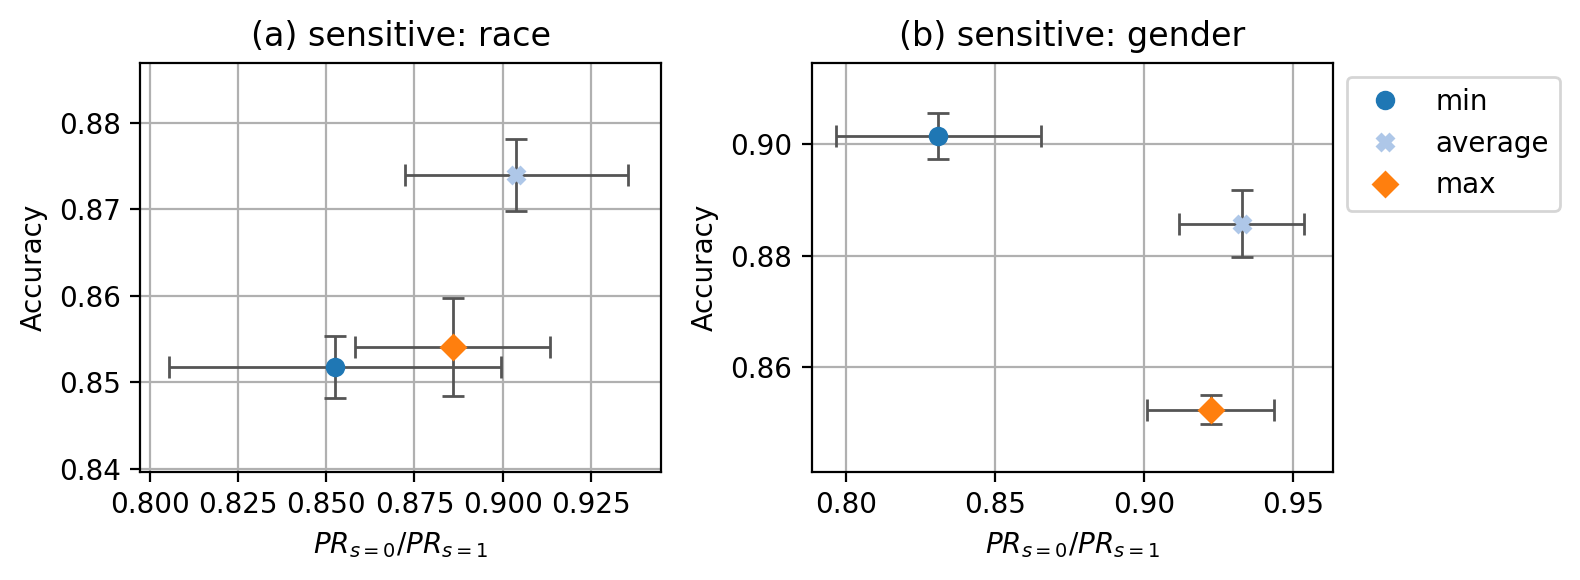

In [69]:
fig, (plot_race, plot_sex) = plt.subplots(ncols=2, figsize=(8, 3), dpi=200)
df_race = pd.read_csv("results/dp_balanced_test_10repeats_Adult Race-Binary_no_transform.csv")
models = [
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_y1_s0_race}",
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_avg_race}",
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_y1_s1_race}",
]
results_race = Results(df_race.query(map_to_query_str(models)))
single_plot(
    plot_race,
    results_race,
    ("prob_pos_race_White_0/race_White_1", r"$\mathit{PR}_{s=0}/\mathit{PR}_{s=1}$"),
    ("Accuracy", "Accuracy"),
    "Adult Race-Binary",
    "no_transform",
    ptype="cross",
    legend_pos=None,
)
plot_race.set_title("(a) sensitive: race")

df_sex = pd.read_csv("results/dp_balanced_test_10repeats_Adult Sex_no_transform.csv")
mapping = {
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_y1_s0_sex}": "min",
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_avg_sex}": "average",
    f"TuningLR, wd: 0.1, RAdam, PR_t: {rate_y1_s1_sex}": "max",
}
results_sex = filter_and_mapt(df_sex, mapping)
single_plot(
    plot_sex,
    results_sex,
    ("prob_pos_sex_Male_0/sex_Male_1", r"$\mathit{PR}_{s=0}/\mathit{PR}_{s=1}$"),
    ("Accuracy", "Accuracy"),
    "Adult Sex",
    "no_transform",
    ptype="cross",
    legend_pos="outside",
)
plot_sex.set_title("(b) sensitive: gender")
fig.tight_layout()
fig.savefig("adult_tar_choice.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


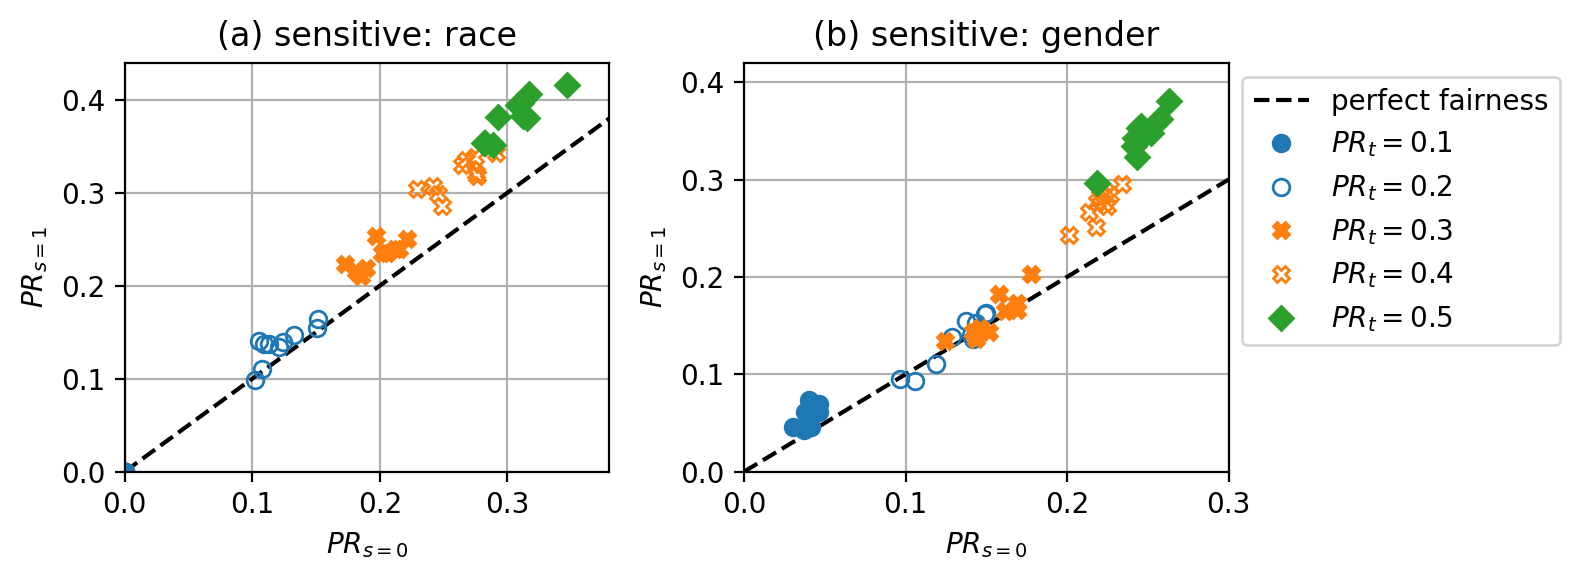

In [86]:
fig, (plot_race, plot_sex) = plt.subplots(ncols=2, figsize=(8, 3), dpi=200)


mapping = {
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.1": r"$\mathit{PR}_t=0.1$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.2": r"$\mathit{PR}_t=0.2$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.3": r"$\mathit{PR}_t=0.3$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.4": r"$\mathit{PR}_t=0.4$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.5": r"$\mathit{PR}_t=0.5$",
}
results_race = Results(df_race.query(map_to_query_str(mapping)))
plot_race.plot([0., 1.], [0., 1.], color='k', linestyle='--', label="perfect fairness")
single_plot(
    plot_race,
    results_race,
    ("prob_pos_race_White_0", r"$\mathit{PR}_{s=0}$"),
    ("prob_pos_race_White_1", r"$\mathit{PR}_{s=1}$"),
    "Adult Race-Binary",
    "no_transform",
    ptype="scatter",
    legend_pos=None,
)
plot_race.set_xlim((0, 0.38))
plot_race.set_ylim((0, 0.44))
plot_race.set_title("(a) sensitive: race")

results_sex = filter_and_mapt(df_sex, mapping)
plot_sex.plot([0., 1.], [0., 1.], color='k', linestyle='--', label="perfect fairness")
single_plot(
    plot_sex,
    results_sex,
    ("prob_pos_sex_Male_0", r"$\mathit{PR}_{s=0}$"),
    ("prob_pos_sex_Male_1", r"$\mathit{PR}_{s=1}$"),
    "Adult Sex",
    "no_transform",
    ptype="scatter",
    legend_pos="outside",
)
plot_sex.set_xlim((0, 0.30))
plot_sex.set_ylim((0, 0.42))
plot_sex.set_title("(b) sensitive: gender")
fig.tight_layout()
fig.savefig("adult_parity_scatter_pr_pr.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


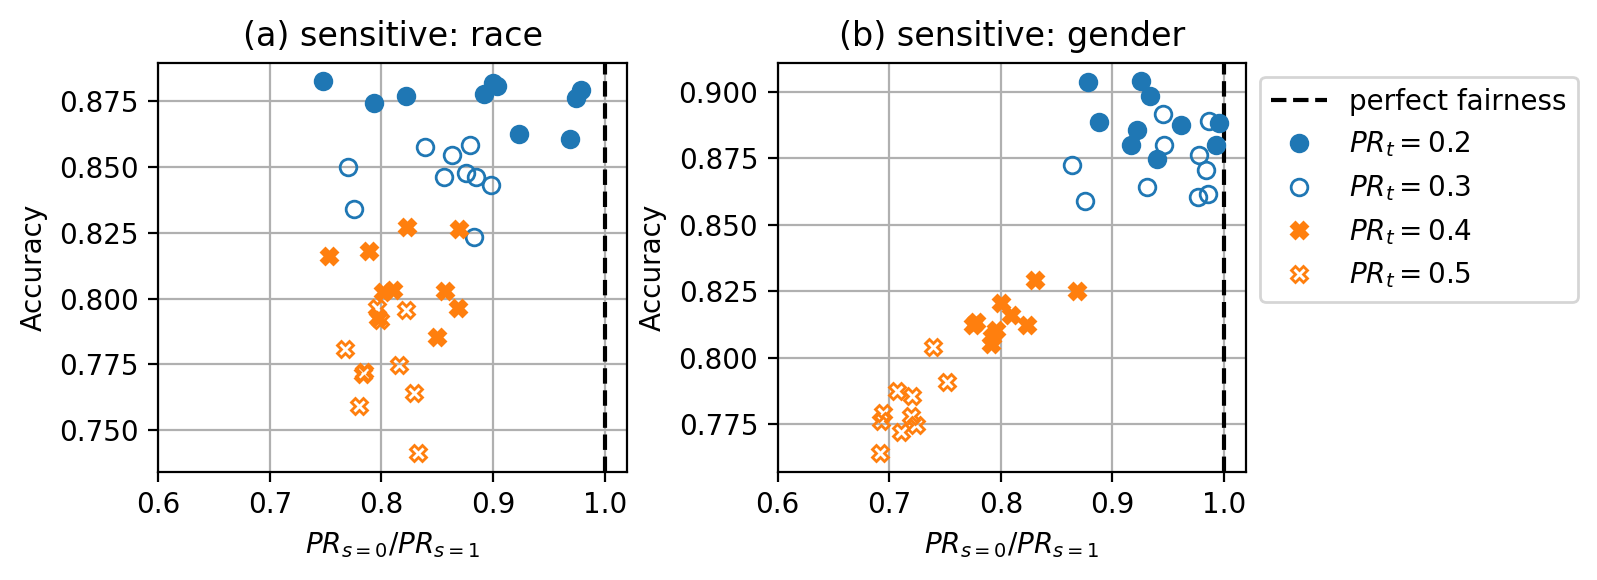

In [87]:
fig, (plot_race, plot_sex) = plt.subplots(ncols=2, figsize=(8, 3), dpi=200)

mapping = {
#     "TuningLR, wd: 0.1, RAdam, PR_t: 0.1": r"$\mathit{PR}_t=0.1$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.2": r"$\mathit{PR}_t=0.2$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.3": r"$\mathit{PR}_t=0.3$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.4": r"$\mathit{PR}_t=0.4$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.5": r"$\mathit{PR}_t=0.5$",
}
results_race = Results(df_race.query(map_to_query_str(mapping)))
plot_race.axvline(x=1.0, linestyle='--', color='k', label="perfect fairness")
single_plot(
    plot_race,
    results_race,
    ("prob_pos_race_White_0/race_White_1", r"$\mathit{PR}_{s=0}/\mathit{PR}_{s=1}$"),
    ("Accuracy", "Accuracy"),
    "Adult Race-Binary",
    "no_transform",
    ptype="scatter",
    legend_pos=None,
)
plot_race.set_xlim((0.6, 1.02))
# plot_race.set_ylim((0, 0.44))
plot_race.set_title("(a) sensitive: race")

results_sex = filter_and_mapt(df_sex, mapping)
plot_sex.axvline(x=1.0, linestyle='--', color='k', label="perfect fairness")
single_plot(
    plot_sex,
    results_sex,
    ("prob_pos_sex_Male_0/sex_Male_1", r"$\mathit{PR}_{s=0}/\mathit{PR}_{s=1}$"),
    ("Accuracy", "Accuracy"),
    "Adult Sex",
    "no_transform",
    ptype="scatter",
    legend_pos="outside",
)
plot_sex.set_xlim((0.6, 1.02))
# plot_sex.set_ylim((0, 0.42))
plot_sex.set_title("(b) sensitive: gender")
fig.tight_layout()
fig.savefig("adult_parity_scatter_acc.eps")

In [90]:
df_eq_race = pd.read_csv("results/eq_normal_test_10repeats_Compas Race_no_transform.csv")
df_eq_sex = pd.read_csv("results/eq_normal_test_10repeats_Compas Sex_no_transform.csv")
df_eq_race_baselines = pd.read_csv("../../EthicML/examples/results/kamiran_calders_variants_proportional_Compas Race_no_transform.csv")
df_eq_sex_baselines = pd.read_csv("../../EthicML/examples/results/kamiran_calders_variants_proportional_Compas Sex_no_transform.csv")

df_eq_race = pd.concat([df_eq_race, df_eq_race_baselines.query("model == 'SVM'")], axis="index", sort=False)
df_eq_sex = pd.concat([df_eq_sex, df_eq_sex_baselines.query("model == 'SVM'")], axis="index", sort=False)

In [91]:
eq_mapping = {
    "Logistic Regression, C=1.0": "LR",
#     "TuningLR, wd: 0.1, RAdam, PR_t: 0.1": r"$\mathit{PR}_t=0.1$",
#     "TuningLR, wd: 0.1, RAdam, PR_t: 0.2": r"ours, $\mathit{PR}_t=0.2$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.3": r"ours, $\mathit{PR}_t=0.3$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.4": r"ours, $\mathit{PR}_t=0.4$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.5": r"ours, $\mathit{PR}_t=0.5$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.6": r"ours, $\mathit{PR}_t=0.6$",
    "TuningLR, wd: 0.1, RAdam, PR_t: 0.7": r"ours, $\mathit{PR}_t=0.7$",
#     "TuningLR, wd: 0.1, RAdam, PR_t: 0.8": r"ours, $\mathit{PR}_t=0.8$",
    "SVM": "SVM",
    "Agarwal, LR, EqOd": "Agarwal LR",
#     "Agarwal, LR, DP": "Agarwal 2",
    "ZafarEqOpp, τ=5.0, μ=1.2": "ZafarEqOpp, τ=5.0, μ=1.2",
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


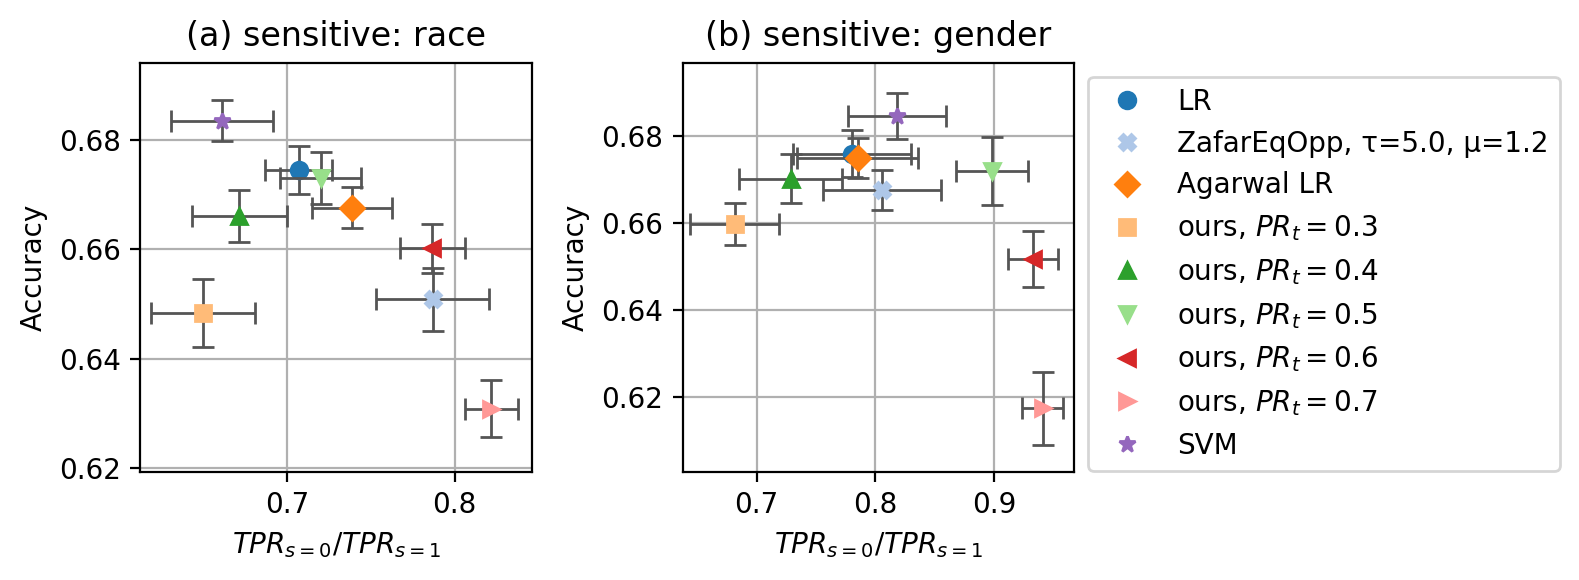

In [92]:
fig, (plot_race, plot_sex) = plt.subplots(ncols=2, figsize=(8, 3), dpi=200)


results_race = Results(df_eq_race.query(map_to_query_str(eq_mapping)))
# plot_race.axvline(x=1.0, linestyle='--', color='k', label="perfect fairness")
single_plot(
    plot_race,
    results_race,
    ("TPR_race_0/race_1", r"$\mathit{TPR}_{s=0}/\mathit{TPR}_{s=1}$"),
    ("Accuracy", "Accuracy"),
    "Compas Race",
    "no_transform",
    ptype="cross",
    legend_pos=None,
)
# plot_race.set_xlim((0.6, 1.02))
# plot_race.set_ylim((0, 0.44))
plot_race.set_title("(a) sensitive: race")

results_sex = filter_and_mapt(df_eq_sex, eq_mapping)
# plot_sex.axvline(x=1.0, linestyle='--', color='k', label="perfect fairness")
single_plot(
    plot_sex,
    results_sex,
    ("TPR_sex_0/sex_1", r"$\mathit{TPR}_{s=0}/\mathit{TPR}_{s=1}$"),
    ("Accuracy", "Accuracy"),
    "Compas Sex",
    "no_transform",
    ptype="cross",
    legend_pos="outside",
)
# plot_sex.set_xlim((0.6, 1.02))
# plot_sex.set_ylim((0, 0.42))
plot_sex.set_title("(b) sensitive: gender")
fig.tight_layout()
fig.savefig("propublica_opp_box_with_agarwal.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


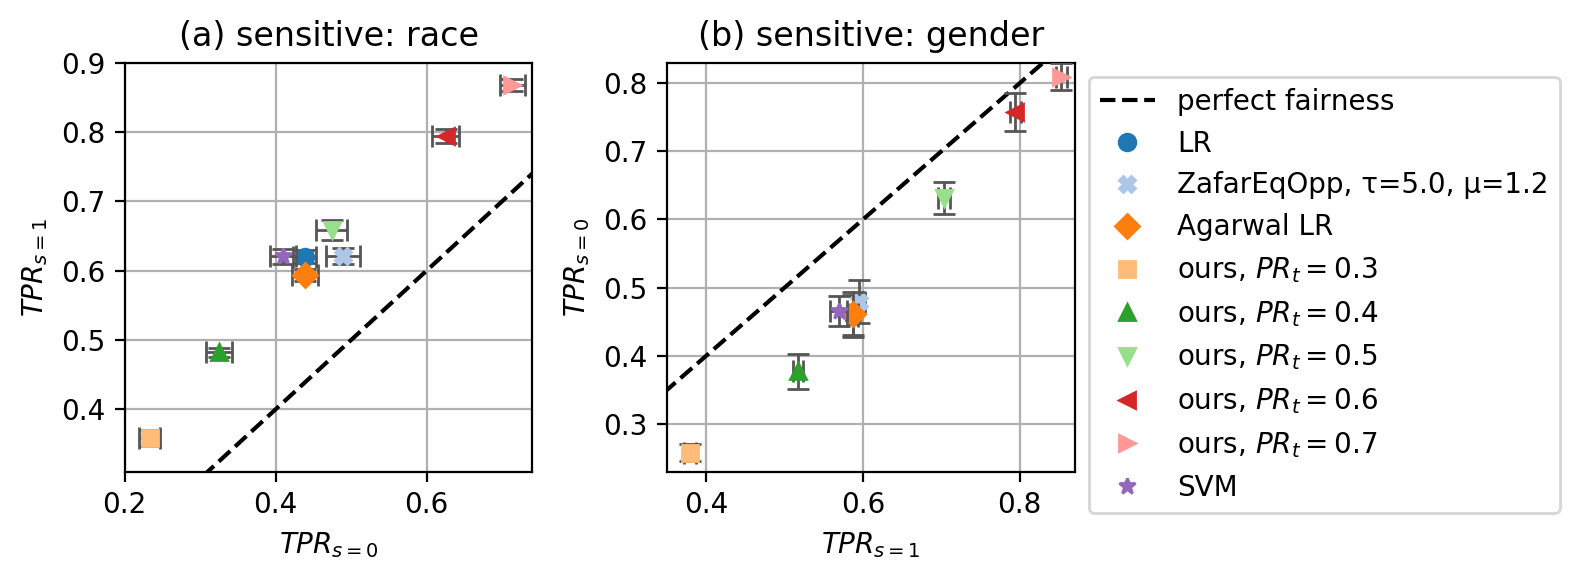

In [93]:
fig, (plot_race, plot_sex) = plt.subplots(ncols=2, figsize=(8, 3), dpi=200)


results_race = Results(df_eq_race.query(map_to_query_str(eq_mapping)))
plot_race.plot([0., 1.], [0., 1.], color='k', linestyle='--', label="perfect fairness")
single_plot(
    plot_race,
    results_race,
    ("TPR_race_1", r"$\mathit{TPR}_{s=0}$"),
    ("TPR_race_0", r"$\mathit{TPR}_{s=1}$"),
    "Compas Race",
    "no_transform",
    ptype="cross",
    legend_pos=None,
)
plot_race.set_xlim((0.2, 0.74))
plot_race.set_ylim((0.31, 0.90))
plot_race.set_title("(a) sensitive: race")

results_sex = filter_and_mapt(df_eq_sex, eq_mapping)
plot_sex.plot([0., 1.], [0., 1.], color='k', linestyle='--', label="perfect fairness")
single_plot(
    plot_sex,
    results_sex,
    ("TPR_sex_1", r"$\mathit{TPR}_{s=1}$"),
    ("TPR_sex_0", r"$\mathit{TPR}_{s=0}$"),
    "Compas Sex",
    "no_transform",
    ptype="cross",
    legend_pos="outside",
)
plot_sex.set_xlim((0.35, 0.87))
plot_sex.set_ylim((0.23, 0.83))
plot_sex.set_title("(b) sensitive: gender")
fig.tight_layout()
fig.savefig("propublica_opp_scatter_tpr.eps")